Import Modul

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [10]:
df = pd.read_csv('smmh.csv')
print("Dataset berhasil diload")
    
# Mengganti nama kolom agar lebih mudah dipanggil
df.columns = df.columns.str.replace(r'^\d+\W*\s*|\s*\(\d+-\d+\)$|\?$|^\s*|\s*$', '', regex=True)
df.rename(columns={
    'What is your age': 'Age',
    'Gender': 'Gender',
    'Relationship Status': 'Relationship_Status',
    'Occupation Status': 'Occupation_Status',
    'Do you use social media': 'Use_Social_Media',
    'What is the average time you spend on social media every day': 'Avg_Time_Social_Media',
    'How often do you find yourself using Social media without a specific purpose': 'SM_No_Purpose',
    'How often do you get distracted by Social media when you are busy doing something': 'SM_Distraction_Busy',
    'Do you feel restless if you haven_t used Social media in a while': 'SM_Restless',
    'On a scale of 1 to 5, how easily distracted are you': 'Easily_Distracted',
    'On a scale of 1 to 5, how much are you bothered by worries': 'Bothered_By_Worries',
    'Do you find it difficult to concentrate on things': 'Difficult_To_Concentrate',
    'On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media': 'SM_Compare_Success',
    'Following the previous question, how do you feel about these comparisons, generally': 'SM_Compare_Feeling',
    'How often do you look to seek validation from features of social media': 'SM_Seek_Validation',
    'How often do you feel depressed or down': 'Feel_Depressed',
    'On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate': 'Interest_Fluctuation',
    'On a scale of 1 to 5, how often do you face issues regarding sleep': 'Sleep_Issues'
}, inplace=True)
print("\nNama kolom setelah disederhanakan (beberapa contoh):")
print(df[['Age', 'Gender', 'Avg_Time_Social_Media', 'SM_No_Purpose', 'Feel_Depressed']].head())
    


Dataset berhasil diload

Nama kolom setelah disederhanakan (beberapa contoh):
    Age  Gender  Avg_Time_Social_Media  SM_No_Purpose  Feel_Depressed
0  21.0    Male  Between 2 and 3 hours              5               5
1  21.0  Female      More than 5 hours              4               5
2  21.0  Female  Between 3 and 4 hours              3               4
3  21.0  Female      More than 5 hours              4               4
4  21.0  Female  Between 2 and 3 hours              3               4


--- 2. Preprocessing ---

In [11]:
# K-Means Features
# Intensitas: Avg_Time_Social_Media (perlu ordinal encoding), SM_No_Purpose
# Gangguan Konsentrasi: Rata-rata dari SM_Distraction_Busy, Easily_Distracted, Difficult_To_Concentrate
# Pencarian Validasi: Rata-rata dari SM_Seek_Validation, SM_Compare_Success
# Tingkat Kecemasan: Bothered_By_Worries
# Membuat fitur komposit untuk K-Means
df['KMeans_Gangguan_Konsentrasi'] = df[['SM_Distraction_Busy', 'Easily_Distracted', 'Difficult_To_Concentrate']].mean(axis=1)
df['KMeans_Pencarian_Validasi'] = df[['SM_Seek_Validation', 'SM_Compare_Success']].mean(axis=1)
# Kolom untuk K-Means
kolom_kmeans_numerik = ['SM_No_Purpose', 'KMeans_Gangguan_Konsentrasi', 'KMeans_Pencarian_Validasi', 'Bothered_By_Worries']
kolom_kmeans_kategori_ordinal = ['Avg_Time_Social_Media']

df_kmeans_selection = df[kolom_kmeans_numerik + kolom_kmeans_kategori_ordinal].copy()
# Ordinal Encoding untuk 'Avg_Time_Social_Media'
time_categories = ['Less than 1 hour', '1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours', 'More than 5 hours']
ordinal_encoder_time = OrdinalEncoder(categories=[time_categories], handle_unknown='use_encoded_value', unknown_value=np.nan) # atau -1

df_kmeans_selection['Avg_Time_Social_Media_Encoded'] = ordinal_encoder_time.fit_transform(df_kmeans_selection[['Avg_Time_Social_Media']])
# Hapus kolom asli setelah di-encode
df_kmeans_processed = df_kmeans_selection.drop(columns=['Avg_Time_Social_Media'])
kolom_kmeans_final = ['Avg_Time_Social_Media_Encoded'] + kolom_kmeans_numerik
# Isi missing values (jika ada setelah encoding atau dari rata-rata)
for col in kolom_kmeans_final:
    if df_kmeans_processed[col].isnull().any():
        df_kmeans_processed[col] = df_kmeans_processed[col].fillna(df_kmeans_processed[col].median())
        print(f"Missing values di '{col}' (K-Means) diisi dengan median.")

# Scaling untuk K-Means
scaler_kmeans = StandardScaler()
kmeans_scaled = scaler_kmeans.fit_transform(df_kmeans_processed[kolom_kmeans_final])
print("\nData K-Means setelah preprocessing dan scaling (5 baris pertama):")
print(pd.DataFrame(kmeans_scaled, columns=kolom_kmeans_final).head())

Missing values di 'Avg_Time_Social_Media_Encoded' (K-Means) diisi dengan median.

Data K-Means setelah preprocessing dan scaling (5 baris pertama):
   Avg_Time_Social_Media_Encoded  SM_No_Purpose  KMeans_Gangguan_Konsentrasi  \
0                            0.0       1.321256                     0.937843   
1                            0.0       0.408147                     0.329888   
2                            0.0      -0.504963                    -0.582044   
3                            0.0       0.408147                    -0.582044   
4                            0.0      -0.504963                     1.241820   

   KMeans_Pencarian_Validasi  Bothered_By_Worries  
0                  -0.575831            -1.216245  
1                   0.319079             1.123810  
2                  -0.575831             1.123810  
3                   0.766534             1.123810  
4                   0.319079             1.123810  


 --- 3. K-Means Clustering ---


Mencari K optimal dengan Elbow Method...


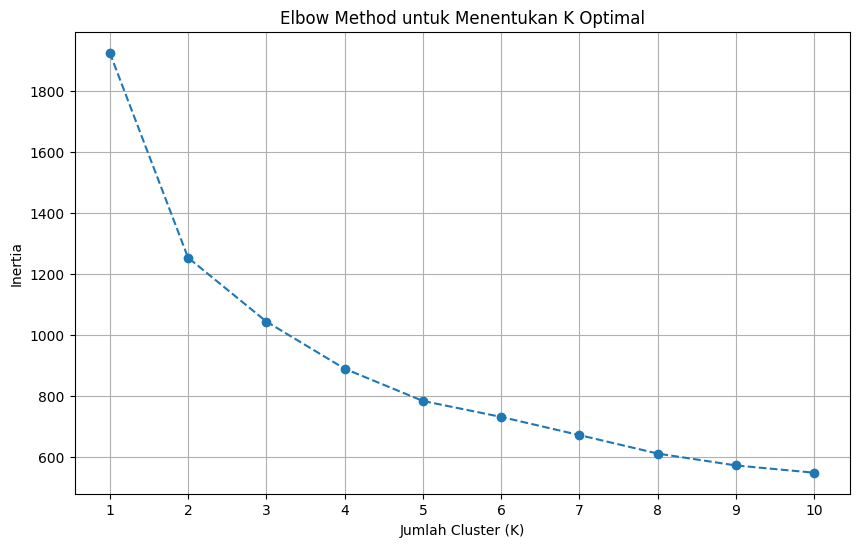

Perhatiin grafiknya, cari 'siku' nya buat nentuin K yang pas.

Hasil clustering K-Means (K=3), 5 baris pertama dengan label cluster:
   Avg_Time_Social_Media_Encoded  SM_No_Purpose  KMeans_Gangguan_Konsentrasi  \
0                            5.0              5                     4.333333   
1                            5.0              4                     3.666667   
2                            5.0              3                     2.666667   
3                            5.0              4                     2.666667   
4                            5.0              3                     4.666667   

   KMeans_Pencarian_Validasi  Bothered_By_Worries  Cluster_KMeans  
0                        2.0                    2               2  
1                        3.0                    5               0  
2                        2.0                    5               2  
3                        3.5                    5               0  
4                        3.0                  

In [12]:
print("\nMencari K optimal dengan Elbow Method...")
inertia = []
K_range = range(1, 11)
for k_val in K_range:
    kmeans_model = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans_model.fit(kmeans_scaled)
    inertia.append(kmeans_model.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.xticks(K_range)
plt.grid(True)
plt.show()
print("Perhatiin grafiknya, cari 'siku' nya buat nentuin K yang pas.")

k_optimal = int(input("Masukkan nilai K optimal berdasarkan Elbow Method: "))

final_kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
df['Cluster_KMeans'] = final_kmeans.fit_predict(kmeans_scaled)
print(f"\nHasil clustering K-Means (K={k_optimal}), 5 baris pertama dengan label cluster:")
# Gabungkan kembali dengan fitur asli (sebelum scaling) untuk interpretasi
df_kmeans_final_interpret = df_kmeans_processed[kolom_kmeans_final].copy()
df_kmeans_final_interpret['Cluster_KMeans'] = df['Cluster_KMeans']
print(df_kmeans_final_interpret.head())
print("\nKarakteristik rata-rata per cluster (fitur yang sudah di-encode dan di-scale):")
# Buat dataframe dari kmeans_scaled untuk groupby yang benar
df_scaled_with_clusters = pd.DataFrame(kmeans_scaled, columns=kolom_kmeans_final)
df_scaled_with_clusters['Cluster_KMeans'] = df['Cluster_KMeans']
print(df_scaled_with_clusters.groupby('Cluster_KMeans').mean())

--- 4. Supervised Learning: Random Forest ---

In [13]:
# Fitur untuk Random Forest
fitur_rf_numerik = ['Age', 'SM_No_Purpose']
fitur_rf_kategori_nominal = ['Gender', 'Relationship_Status']
fitur_rf_kategori_ordinal = ['Avg_Time_Social_Media']
# Menyiapkan Preprocessor untuk Random Forest
# OrdinalEncoder untuk Avg_Time_Social_Media
# OneHotEncoder untuk Gender, Relationship_Status
# StandardScaler untuk Age, SM_No_Purpose, SM_Seek_Validation
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[time_categories], handle_unknown='use_encoded_value', unknown_value=-1), fitur_rf_kategori_ordinal), # Pake -1 atau np.nan
        ('onehot', OneHotEncoder(handle_unknown='ignore'), fitur_rf_kategori_nominal),
        ('num', StandardScaler(), fitur_rf_numerik)
    ], 
    remainder='passthrough'
)

# Target: Mengalami Depresi (Feel_Depressed), Mengalami Gangguan Tidur (Sleep_Issues)
# Binarisasi Target (skor >= 4 dianggap "Ya" (1), selain itu "Tidak" (0))
threshold = 4 
df['Target_Depresi'] = df['Feel_Depressed'].apply(lambda x: 1 if x >= threshold else 0)
df['Target_Gangguan_Tidur'] = df['Sleep_Issues'].apply(lambda x: 1 if x >= threshold else 0)
print(f"\nDistribusi target Depresi (1 = Ya >= {threshold}, 0 = Tidak < {threshold}):")
print(df['Target_Depresi'].value_counts(normalize=True))
print(f"Distribusi target Gangguan Tidur (1 = Ya >= {threshold}, 0 = Tidak < {threshold}):")
print(df['Target_Gangguan_Tidur'].value_counts(normalize=True))
kolom_fitur_rf_gabungan = fitur_rf_numerik + fitur_rf_kategori_nominal + fitur_rf_kategori_ordinal
X = df[kolom_fitur_rf_gabungan]


Distribusi target Depresi (1 = Ya >= 4, 0 = Tidak < 4):
0    0.540541
1    0.459459
Name: Target_Depresi, dtype: float64
Distribusi target Gangguan Tidur (1 = Ya >= 4, 0 = Tidak < 4):
0    0.511435
1    0.488565
Name: Target_Gangguan_Tidur, dtype: float64


--- Model Prediksi Depresi ---


--- Membangun Model Prediksi Depresi ---
Melatih model prediksi depresi...

Hasil Evaluasi Model Prediksi Depresi:
Akurasi: 0.6529
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        65
           1       0.61      0.68      0.64        56

    accuracy                           0.65       121
   macro avg       0.65      0.65      0.65       121
weighted avg       0.66      0.65      0.65       121

Confusion Matrix:


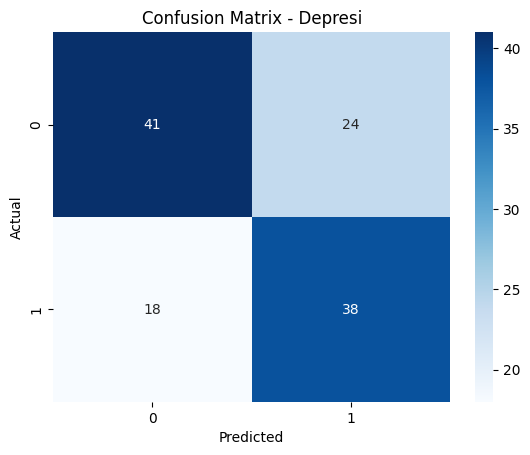

In [14]:
print(f"\n--- Membangun Model Prediksi Depresi ---")
y_depresi = df['Target_Depresi']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_depresi, test_size=0.25, random_state=42, stratify=y_depresi)
model_depresi_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                                         ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))]) # class_weight balanced jika data tidak seimbang

print("Melatih model prediksi depresi...")
model_depresi_pipeline.fit(X_train_d, y_train_d)
y_pred_d = model_depresi_pipeline.predict(X_test_d)

print("\nHasil Evaluasi Model Prediksi Depresi:")
print(f"Akurasi: {accuracy_score(y_test_d, y_pred_d):.4f}")
print("Laporan Klasifikasi:")
print(classification_report(y_test_d, y_pred_d, zero_division=0))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test_d, y_pred_d), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Depresi')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

--- Model Prediksi Gangguan Tidur ---


--- Membangun Model Prediksi Gangguan Tidur ---
Melatih model prediksi gangguan tidur...

Hasil Evaluasi Model Prediksi Gangguan Tidur:
Akurasi: 0.5372
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54        62
           1       0.52      0.54      0.53        59

    accuracy                           0.54       121
   macro avg       0.54      0.54      0.54       121
weighted avg       0.54      0.54      0.54       121

Confusion Matrix:


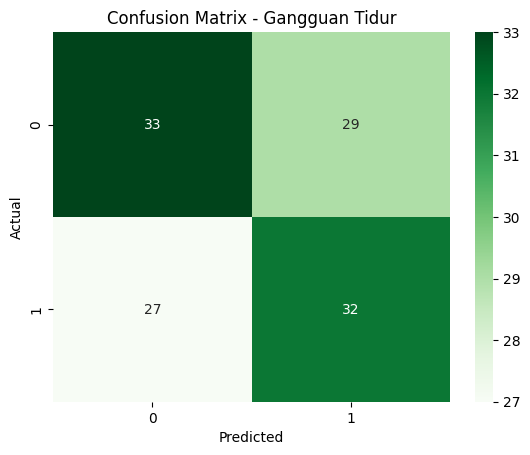

In [15]:
print(f"\n--- Membangun Model Prediksi Gangguan Tidur ---")
y_tidur = df['Target_Gangguan_Tidur']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_tidur, test_size=0.25, random_state=42, stratify=y_tidur)

model_tidur_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                                       ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))])

print("Melatih model prediksi gangguan tidur...")
model_tidur_pipeline.fit(X_train_t, y_train_t)
y_pred_t = model_tidur_pipeline.predict(X_test_t)
print("\nHasil Evaluasi Model Prediksi Gangguan Tidur:")
print(f"Akurasi: {accuracy_score(y_test_t, y_pred_t):.4f}")
print("Laporan Klasifikasi:")
print(classification_report(y_test_t, y_pred_t, zero_division=0))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test_t, y_pred_t), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Gangguan Tidur')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Penelitian ini telah berhasil menjalankan dua pendekatan utama dalam analisis data:

Melalui pendekatan unsupervised learning dengan algoritma K-Means Clustering, penelitian ini berhasil mengelompokkan responden berdasarkan pola kebiasaan penggunaan media sosial dan gejala kesehatan mental yang terukur (seperti intensitas penggunaan, gangguan konsentrasi, pencarian validasi, dan tingkat kecemasan). Proses ini mengungkapkan adanya segmen-segmen pengguna yang berbeda, masing-masing dengan karakteristik unik terkait interaksi mereka dengan media sosial dan dampaknya terhadap aspek psikologis.

Sementara itu, melalui pendekatan supervised learning dengan algoritma Random Forest, penelitian ini berupaya untuk memprediksi status kesehatan mental (dalam kasus ini, indikasi depresi dan gangguan tidur) dari pola penggunaan media sosial responden, yang dilengkapi dengan data demografis. Model prediktif yang dibangun menunjukkan potensi (dengan tingkat akurasi, presisi, dan recall yang perlu King Akhdan pastikan dari output notebooknya) untuk identifikasi dini individu yang mungkin berisiko.

Secara keseluruhan, temuan dari kedua pendekatan ini saling melengkapi. Identifikasi segmen pengguna dengan karakteristik tertentu (hasil unsupervised) dapat memberikan konteks yang lebih kaya dalam memahami faktor-faktor yang berkontribusi terhadap status kesehatan mental yang diprediksi (hasil supervised). Penelitian ini memberikan wawasan awal yang berharga mengenai kompleksitas hubungan antara perilaku digital dan kondisi psikologis. Lebih lanjut, hasil ini dapat menjadi dasar yang konstruktif untuk pengembangan intervensi atau solusi berbasis data yang lebih personal dan efektif, guna mendukung kesehatan mental masyarakat di era digital yang terus berkembang.